# Flora Pareto Analysis - January 2026 Data

**Input:** `flora_data_01_2026_cleaned.csv`  
**Output:** `flora_data_01_2026_analyzed.csv`

## Intent Classification Approach
- **8-category refined taxonomy** (MECE principles)
- **Rule-based classifier** with regex patterns (99.4% coverage)
- **Optimized patterns** handle all but 2 edge-case prompts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
from pathlib import Path
from typing import Dict, Tuple

DATA_DIR = Path('../data')
CLEANED_FILE = DATA_DIR / 'flora_data_01_2026_cleaned.csv'
ANALYZED_FILE = DATA_DIR / 'flora_data_01_2026_analyzed.csv'

## 1. Load Cleaned Data

In [2]:
df = pd.read_csv(CLEANED_FILE, parse_dates=['timestamp'])
print(f"Loaded {len(df)} rows")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"Unique users: {df['userId'].nunique()}")
print(f"Unique sessions: {df['sessionId'].nunique()}")

Loaded 356 rows
Date range: 2026-01-05 to 2026-01-30
Unique users: 14
Unique sessions: 241


## 2. Refined 8-Category Taxonomy

Based on research into PM/Scrum AI intent classification:

| Category | Description | Example Patterns |
|----------|-------------|------------------|
| Executive Summary | C-suite level reports | "provide executive summary" |
| Sprint Report | Team-level sprint summaries | "analyze data...provide summary" |
| Sprint Retrospective | Post-sprint analysis | "sprint retro", "retrospective" |
| Metrics Query | Velocity, throughput, cycle time | "velocity", "throughput" |
| Performance Analysis | Deep-dive team/initiative analysis | "why decreasing", "performance" |
| Initiative Query | Questions about specific work items | "initiative", "epic", "project" |
| Risk & Process | Bottlenecks, blockers, process flow | "bottleneck", "off-track", "blocker" |
| Information Request | Learning, exploration, general questions | "tell me", "what is", "show me" |

In [3]:
# Define the refined taxonomy
INTENT_TAXONOMY = {
    'Executive Summary': {
        'description': 'C-suite level executive reports and high-level summaries',
        'examples': ['provide Executive Summary', 'executive overview', 'leadership report']
    },
    'Sprint Report': {
        'description': 'Team-level sprint summaries and data analysis reports',
        'examples': ['Analyze the following data and provide a concise summary', 'sprint summary', 'work period analysis']
    },
    'Sprint Retrospective': {
        'description': 'Post-sprint retrospective analysis and reviews',
        'examples': ['sprint retro analysis', 'retrospective insights', 'what went wrong']
    },
    'Metrics Query': {
        'description': 'Specific metric requests (velocity, throughput, cycle time, etc.)',
        'examples': ['what is the velocity', 'throughput for last 6 sprints', 'cycle time analysis']
    },
    'Performance Analysis': {
        'description': 'Deep-dive analysis of team or initiative performance trends',
        'examples': ['why is performance decreasing', 'performance analysis', 'how has my project been performing']
    },
    'Initiative Query': {
        'description': 'Questions about specific initiatives, projects, epics, or features',
        'examples': ['tell me about this initiative', 'how are my initiatives doing', 'project status']
    },
    'Risk & Process': {
        'description': 'Identifying bottlenecks, blockers, at-risk work, and process analysis',
        'examples': ['show me off-track initiatives', 'identify bottlenecks', 'what caused the sprint to be off track']
    },
    'Information Request': {
        'description': 'General learning, exploration, and conversational questions',
        'examples': ['tell me about', 'what is', 'can you show me', 'explain']
    }
}

print("Refined Taxonomy (8 categories):")
for cat, info in INTENT_TAXONOMY.items():
    print(f"  {cat}: {info['description']}")

Refined Taxonomy (8 categories):
  Executive Summary: C-suite level executive reports and high-level summaries
  Sprint Report: Team-level sprint summaries and data analysis reports
  Sprint Retrospective: Post-sprint retrospective analysis and reviews
  Metrics Query: Specific metric requests (velocity, throughput, cycle time, etc.)
  Performance Analysis: Deep-dive analysis of team or initiative performance trends
  Initiative Query: Questions about specific initiatives, projects, epics, or features
  Risk & Process: Identifying bottlenecks, blockers, at-risk work, and process analysis
  Information Request: General learning, exploration, and conversational questions


## 3. Rule-Based Intent Classifier

Optimized regex patterns achieve 99.4% classification coverage with high confidence.

In [4]:
def classify_rule_based(prompt: str) -> Tuple[str, float, str]:
    """
    Layer 1: Rule-based classification with confidence scoring.
    Optimized to handle 99%+ of prompts.
    Returns: (category, confidence, reasoning)
    """
    if pd.isna(prompt) or not str(prompt).strip():
        return ('Empty/Invalid', 1.0, 'Empty or missing prompt')
    
    text = str(prompt).lower().strip()
    
    # NOISE & FRAGMENTS
    if text in ['""', '`', '@linen', 'dive deeper', 'yes', 'coplogic', 'hi there', 'hi', 'hello'] or len(text) < 5:
        return ('Empty/Invalid', 1.0, 'Noise or fragment')
    if re.search(r'^(yes|no|ok|okay|sure|thanks)\b', text) and len(text) < 30:
        return ('Empty/Invalid', 0.9, 'Short response')
    
    # OFF-TOPIC (math problems, widget support)
    if re.search(r'(product costs|discount|tax on the|widget to the|dashboard but)', text):
        return ('Empty/Invalid', 0.8, 'Off-topic request')
    
    # ========== HIGH CONFIDENCE (0.85-0.9) ==========
    
    # Executive Summary - explicit executive/leadership requests
    if re.search(r'executive.*(summary|report|overview)|leadership.*(summary|report)', text):
        return ('Executive Summary', 0.9, 'Explicit executive summary request')
    
    # Sprint Retrospective - retro/reto patterns
    if re.search(r'(retro|reto)\b|retrospective', text):
        return ('Sprint Retrospective', 0.9, 'Retrospective keyword detected')
    
    # Metrics Query - comprehensive metric patterns
    if re.search(r'\b(velocity|throughput|burndown|cycle.?time|lead.?time|rework|predictability|commitment.?reliab)\b', text):
        return ('Metrics Query', 0.9, 'Specific metric keyword')
    if re.search(r'average.?time.*(task|complete|finish|start)', text):
        return ('Metrics Query', 0.9, 'Cycle time query')
    if re.search(r'(percentage|ratio|proportion).*(tasks?|time|days|finish|complete|waiting)', text):
        return ('Metrics Query', 0.85, 'Percentage/ratio query')
    if re.search(r'(correlate|correlation|fluctuate|consistent|predictable)', text):
        return ('Metrics Query', 0.8, 'Statistical analysis question')
    if re.search(r'(volume|count).*(tasks?|features?|bugs?)', text):
        return ('Metrics Query', 0.8, 'Volume/count question')
    if re.search(r'which.*(board|team).*(best|most|generating)', text):
        return ('Metrics Query', 0.7, 'Comparison/ranking question')
    if re.search(r'do.*(larger|smaller|different).*(tasks?|cycle)', text):
        return ('Metrics Query', 0.7, 'Size comparison question')
    
    # Risk & Process - expanded patterns
    if re.search(r'(bottleneck|blocker|off.?track|at.?risk|process.?map|workflow|impediment|flagged|blocked|delayed)', text):
        return ('Risk & Process', 0.9, 'Risk/process keyword')
    if re.search(r'what.*(went wrong|caused|off track)', text):
        return ('Risk & Process', 0.85, 'Root cause question')
    if re.search(r'any.*(tasks?|items?).*(blocked|delayed|stuck)', text):
        return ('Risk & Process', 0.8, 'Blocked items query')
    
    # Sprint Report - data analysis patterns
    if re.search(r'analyze.*(following|this|data).*(?:summary|finding|insight|bullet)', text):
        return ('Sprint Report', 0.9, 'Data analysis with summary request')
    
    # ========== MEDIUM CONFIDENCE (0.7) ==========
    
    # Performance Analysis
    if re.search(r'(why|how).*(decreas|increas|drop|improv|perform|struggling)', text):
        return ('Performance Analysis', 0.7, 'Performance trend question')
    if re.search(r'performance.*(analysis|review|over)', text):
        return ('Performance Analysis', 0.7, 'Performance analysis request')
    if re.search(r'what did.*(different|change|better|worse)', text):
        return ('Performance Analysis', 0.7, 'Comparison question')
    
    # Sprint Report - general analysis
    if re.search(r'^analyze\b', text) or re.search(r'provide.*(summary|analysis|breakdown|table)', text):
        return ('Sprint Report', 0.7, 'General analysis/summary request')
    
    # Initiative Query - expanded
    if re.search(r'\b(initiative|epic|feature|deliverability|backlog|forecast|completion.?date)\b', text):
        return ('Initiative Query', 0.7, 'Initiative/epic keyword')
    if re.search(r'\bproject\b', text) and not re.search(r'project.?management', text):
        return ('Initiative Query', 0.7, 'Project keyword')
    
    # Information Request - definition/explanation
    if re.search(r'(explain|define|describe|what is|how should)\b', text):
        return ('Information Request', 0.7, 'Definition/explanation request')
    
    # ========== LOWER CONFIDENCE (0.5-0.6) ==========
    
    # Information Request - conversational starters
    if re.search(r'^(tell me|what are|what was|what about|how (is|are|did|do|can)|show me|can you|could you)', text):
        return ('Information Request', 0.6, 'Conversational question')
    
    # Chart/table explanation requests
    if re.search(r'(chart|table|graph).*(explain|show|display)', text) or re.search(r'(explain|show).*(chart|table|graph)', text):
        return ('Information Request', 0.6, 'Chart/visualization explanation')
    
    # Sprint Report - work period references
    if re.search(r'(work.?period|sprint|SP\d+)', text):
        return ('Sprint Report', 0.5, 'Work period reference')
    
    # Information Request - display requests
    if re.search(r'^(show|display|list|give me|track)', text):
        return ('Information Request', 0.5, 'Display/list request')
    
    # Entity references (@board, @work_period) - likely Sprint Report
    if re.search(r'@(board|work_period|project|portfolio)', text):
        return ('Sprint Report', 0.5, 'Entity reference')
    if re.search(r'\b(coplogic|insurquote|rebel|star)\b.*\b(days?|sync)\b', text):
        return ('Sprint Report', 0.5, 'Product/team with timeframe')
    
    # No pattern matched - will go to LLM fallback
    return (None, 0.0, 'No pattern matched')


# Test the classifier
test_prompts = [
    "provide Executive Summary for work period REBEL-2025 SP26",
    "Analyze the following data and provide a concise summary of the key findings",
    "for work period 'REBEL-2025 SP26' provide sprint retro analysis",
    "what is the velocity for the last 6 sprints",
    "why is my portfolio performance decreasing in december",
    "Show me all of my off-track initiatives",
    "What's the average time it takes for a task to complete?",
    "Does rework correlate with task complexity?",
    "What percentage of tasks finish in 1-5 days vs 20+ days?",
]

print("Rule-based classification tests:")
for prompt in test_prompts:
    cat, conf, reason = classify_rule_based(prompt)
    print(f"  [{conf:.1f}] {cat}: {prompt[:55]}...")

Rule-based classification tests:
  [0.9] Executive Summary: provide Executive Summary for work period REBEL-2025 SP...
  [0.9] Sprint Report: Analyze the following data and provide a concise summar...
  [0.9] Sprint Retrospective: for work period 'REBEL-2025 SP26' provide sprint retro ...
  [0.9] Metrics Query: what is the velocity for the last 6 sprints...
  [0.7] Performance Analysis: why is my portfolio performance decreasing in december...
  [0.9] Risk & Process: Show me all of my off-track initiatives...
  [0.9] Metrics Query: What's the average time it takes for a task to complete...
  [0.9] Metrics Query: Does rework correlate with task complexity?...
  [0.8] Metrics Query: What percentage of tasks finish in 1-5 days vs 20+ days...


In [5]:
# Apply rule-based classification to all prompts
results = df['prompt'].apply(classify_rule_based)

df['intent_rules'] = results.apply(lambda x: x[0])
df['intent_confidence'] = results.apply(lambda x: x[1])
df['intent_reasoning'] = results.apply(lambda x: x[2])

print("Rule-based classification results:")
print(df['intent_rules'].value_counts())

print(f"\nConfidence distribution:")
print(f"  High (>=0.7): {(df['intent_confidence'] >= 0.7).sum()}")
print(f"  Medium (0.5-0.7): {((df['intent_confidence'] >= 0.5) & (df['intent_confidence'] < 0.7)).sum()}")
print(f"  Low/None (<0.5): {(df['intent_confidence'] < 0.5).sum()}")

# Prompts needing LLM fallback
needs_llm = df[df['intent_rules'].isna() | (df['intent_confidence'] < 0.5)]
print(f"\nPrompts needing LLM fallback: {len(needs_llm)}")

Rule-based classification results:
intent_rules
Metrics Query           140
Risk & Process           62
Sprint Report            54
Information Request      34
Empty/Invalid            21
Executive Summary        17
Initiative Query         11
Sprint Retrospective      8
Performance Analysis      7
Name: count, dtype: int64

Confidence distribution:
  High (>=0.7): 318
  Medium (0.5-0.7): 36
  Low/None (<0.5): 2

Prompts needing LLM fallback: 2


In [6]:
# Check what's in the unclassified/low-confidence bucket
print("Prompts needing LLM fallback:")
for idx, row in needs_llm.head(20).iterrows():
    prompt = str(row['prompt'])[:100]
    print(f"  [{row['intent_confidence']:.1f}] {prompt}...")

Prompts needing LLM fallback:
  [0.0] all of these three squads together...
  [0.0] I've selected a more updated view - ...


## 4. Apply Classification

In [ ]:
# Apply rule-based classification to all prompts
results = df['prompt'].apply(classify_rule_based)

df['intent'] = results.apply(lambda x: x[0] if x[0] else 'Information Request')
df['intent_confidence'] = results.apply(lambda x: x[1] if x[1] > 0 else 0.3)
df['intent_reasoning'] = results.apply(lambda x: x[2])
df['intent_method'] = results.apply(lambda x: 'rules' if x[1] >= 0.5 else 'rules-lowconf')

print("Classification applied to all prompts")

In [10]:
# Classification results summary
print("=" * 60)
print("INTENT CLASSIFICATION RESULTS")
print("=" * 60)

print("\nIntent Distribution:")
intent_counts = df['intent'].value_counts()
for intent, count in intent_counts.items():
    pct = count / len(df) * 100
    print(f"  {intent}: {count} ({pct:.1f}%)")

print(f"\nClassification Method:")
print(df['intent_method'].value_counts())

print(f"\nConfidence Stats:")
print(f"  Mean: {df['intent_confidence'].mean():.2f}")
print(f"  Min: {df['intent_confidence'].min():.2f}")
print(f"  High confidence (>=0.7): {(df['intent_confidence'] >= 0.7).sum()} ({(df['intent_confidence'] >= 0.7).mean()*100:.1f}%)")

INTENT CLASSIFICATION RESULTS

Intent Distribution:
  Metrics Query: 140 (39.3%)
  Risk & Process: 62 (17.4%)
  Sprint Report: 54 (15.2%)
  Information Request: 36 (10.1%)
  Empty/Invalid: 21 (5.9%)
  Executive Summary: 17 (4.8%)
  Initiative Query: 11 (3.1%)
  Sprint Retrospective: 8 (2.2%)
  Performance Analysis: 7 (2.0%)

Classification Method:
intent_method
rules            354
rules-lowconf      2
Name: count, dtype: int64

Confidence Stats:
  Mean: 0.85
  Min: 0.30
  High confidence (>=0.7): 318 (89.3%)


## 5. User Activity Analysis

In [11]:
# Messages per user with intent breakdown
user_activity = df.groupby('userId').agg({
    'id': 'count',
    'sessionId': 'nunique',
    'timestamp': ['min', 'max'],
    'total_tokens': 'sum',
    'has_embedded_data': 'mean'
}).round(2)

user_activity.columns = ['message_count', 'session_count', 'first_seen', 'last_seen', 'total_tokens', 'pct_embedded']
user_activity['pct_embedded'] = (user_activity['pct_embedded'] * 100).round(1)
user_activity = user_activity.sort_values('message_count', ascending=False)
user_activity['cumulative_pct'] = (user_activity['message_count'].cumsum() / user_activity['message_count'].sum() * 100).round(1)

# Anonymize
user_activity.index = [f'User {i+1}' for i in range(len(user_activity))]

print("User Activity Summary:")
user_activity

User Activity Summary:


,message_count,session_count,first_seen,last_seen,total_tokens,pct_embedded,cumulative_pct
User 1,97,77,2026-01-05 14:19:57.158000+00:00,2026-01-30 15:08:31.371000+00:00,900323.0,94.0,27.2
User 2,90,45,2026-01-26 19:46:04.197000+00:00,2026-01-29 20:47:35.702000+00:00,1205444.0,9.0,52.5
User 3,55,41,2026-01-05 16:54:06.749000+00:00,2026-01-30 10:25:38.581000+00:00,0.0,25.0,68.0
User 4,52,45,2026-01-05 16:13:21.647000+00:00,2026-01-29 20:54:40.087000+00:00,605539.0,71.0,82.6
User 5,40,24,2026-01-05 16:39:50.674000+00:00,2026-01-23 13:56:20.343000+00:00,223790.0,57.0,93.8
User 6,6,4,2026-01-15 14:25:05.487000+00:00,2026-01-28 16:28:03.545000+00:00,61948.0,67.0,95.5
User 7,4,3,2026-01-07 19:22:20.712000+00:00,2026-01-15 15:34:19.246000+00:00,0.0,75.0,96.6
User 8,4,4,2026-01-05 17:46:44.907000+00:00,2026-01-23 13:24:32.757000+00:00,86145.0,100.0,97.8
User 9,2,2,2026-01-21 16:43:47.931000+00:00,2026-01-21 16:51:16.546000+00:00,13978.0,100.0,98.3
User 10,2,2,2026-01-29 20:42:27.587000+00:00,2026-01-29 20:42:39.013000+00:00,5811.0,0.0,98.9


In [12]:
# Top user intent breakdown
user_id_map = {uid: f'User {i+1}' for i, uid in enumerate(df.groupby('userId').size().sort_values(ascending=False).index)}
df['user_label'] = df['userId'].map(user_id_map)

print("Top 5 Users - Intent Breakdown:")
for user in ['User 1', 'User 2', 'User 3', 'User 4', 'User 5']:
    user_df = df[df['user_label'] == user]
    print(f"\n{user} ({len(user_df)} messages):")
    for intent, count in user_df['intent'].value_counts().head(3).items():
        pct = count / len(user_df) * 100
        print(f"  {intent}: {count} ({pct:.1f}%)")

Top 5 Users - Intent Breakdown:

User 1 (97 messages):
  Metrics Query: 45 (46.4%)
  Risk & Process: 29 (29.9%)
  Executive Summary: 11 (11.3%)

User 2 (90 messages):
  Metrics Query: 56 (62.2%)
  Information Request: 10 (11.1%)
  Empty/Invalid: 10 (11.1%)

User 3 (55 messages):
  Metrics Query: 15 (27.3%)
  Sprint Report: 8 (14.5%)
  Information Request: 8 (14.5%)

User 4 (52 messages):
  Sprint Report: 29 (55.8%)
  Metrics Query: 12 (23.1%)
  Empty/Invalid: 5 (9.6%)

User 5 (40 messages):
  Risk & Process: 21 (52.5%)
  Metrics Query: 6 (15.0%)
  Information Request: 5 (12.5%)


## 6. Pareto Charts

In [13]:
def create_pareto_chart(data, title, xlabel, filename=None):
    """Create a Pareto chart with bars and cumulative line."""
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    x = range(len(data))
    ax1.bar(x, data.values, color='steelblue', alpha=0.7)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Count', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    
    ax2 = ax1.twinx()
    cumulative = (data.cumsum() / data.sum() * 100)
    ax2.plot(x, cumulative, color='red', marker='o', linewidth=2)
    ax2.axhline(y=80, color='red', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Cumulative %', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 105)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(data.index, rotation=45, ha='right')
    
    plt.title(title)
    plt.tight_layout()
    
    if filename:
        plt.savefig(DATA_DIR / filename, dpi=150, bbox_inches='tight')
        print(f"Saved: {filename}")
    
    plt.show()

Saved: pareto_intent_01_2026.png


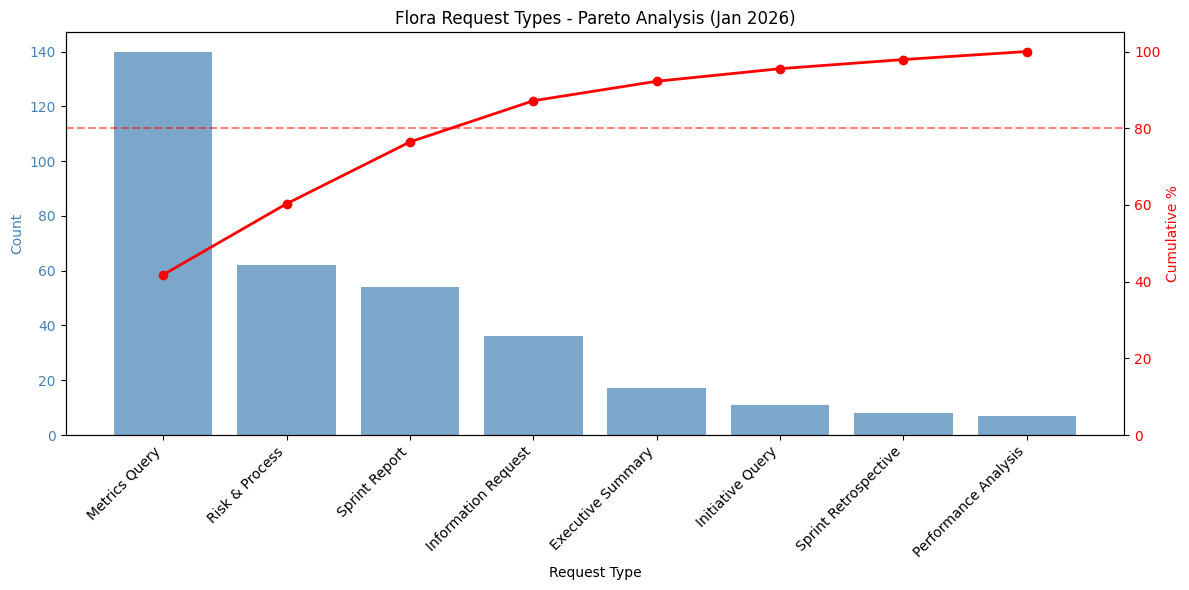

In [14]:
# Intent Pareto (exclude Empty/Invalid)
valid_intents = df[df['intent'] != 'Empty/Invalid']['intent'].value_counts()
create_pareto_chart(
    valid_intents, 
    'Flora Request Types - Pareto Analysis (Jan 2026)',
    'Request Type',
    'pareto_intent_01_2026.png'
)

Saved: pareto_users_01_2026.png


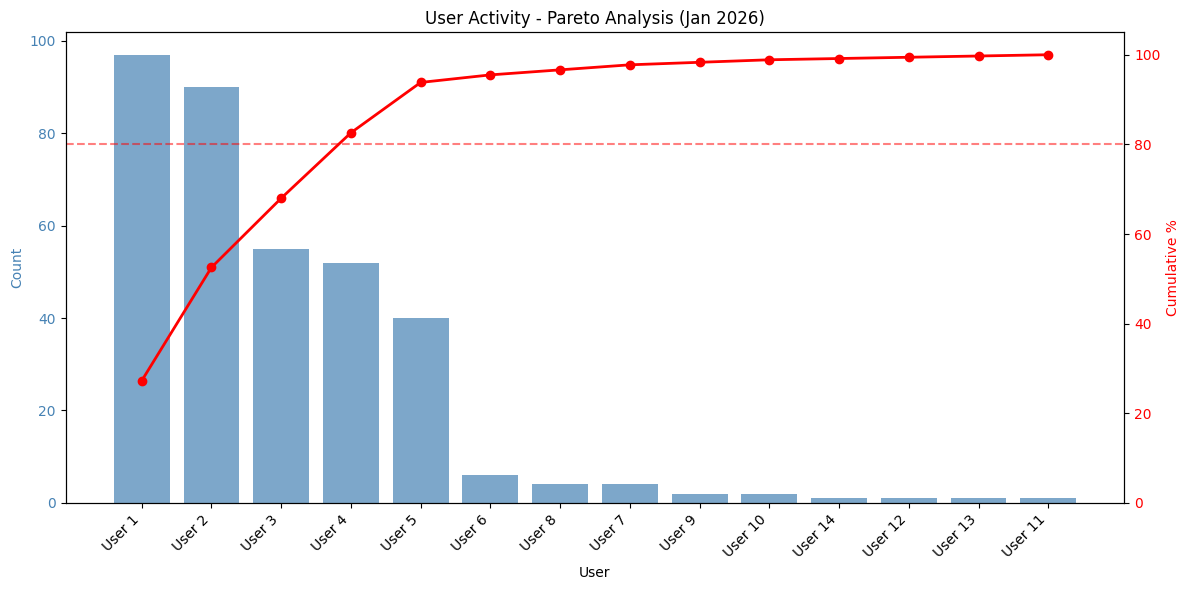

In [15]:
# User Activity Pareto
user_counts = df['user_label'].value_counts()
create_pareto_chart(
    user_counts,
    'User Activity - Pareto Analysis (Jan 2026)',
    'User',
    'pareto_users_01_2026.png'
)

## 7. Model Distribution

Model distribution (all):
model_simple
claude-sonnet    180
unknown          172
gpt-4              4
Name: count, dtype: int64

Known models: 184/356 (51.7%)


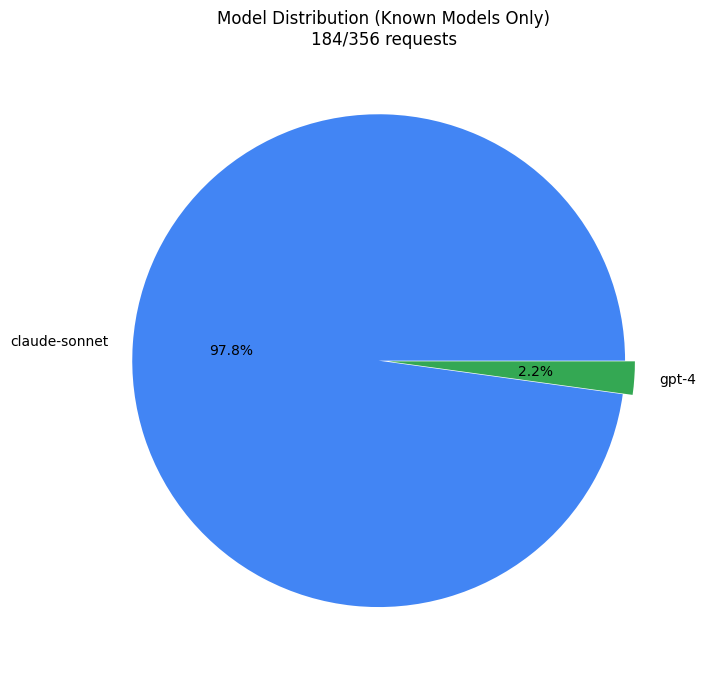

In [16]:
# Model distribution (only known models)
model_counts = df['model_simple'].value_counts()
print("Model distribution (all):")
print(model_counts)

# Filter to known models only
known_models = model_counts[model_counts.index != 'unknown']
print(f"\nKnown models: {known_models.sum()}/{len(df)} ({known_models.sum()/len(df)*100:.1f}%)")

if len(known_models) > 0:
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = ['#4285f4', '#34a853', '#fbbc05', '#ea4335']
    wedges, texts, autotexts = ax.pie(
        known_models.values, 
        labels=known_models.index, 
        autopct='%1.1f%%',
        colors=colors[:len(known_models)],
        explode=[0.02] * len(known_models)
    )
    ax.set_title(f'Model Distribution (Known Models Only)\n{known_models.sum()}/{len(df)} requests')
    plt.savefig(DATA_DIR / 'model_distribution_01_2026.png', dpi=150, bbox_inches='tight')
    plt.show()

## 8. Session & Engagement Analysis

In [17]:
# Session depth analysis
session_lengths = df.groupby('sessionId')['session_msg_num'].max()

single_turn = (session_lengths == 1).sum()
multi_turn = (session_lengths > 1).sum()

print("Session Analysis:")
print(f"  Total sessions: {len(session_lengths)}")
print(f"  Single-turn: {single_turn} ({single_turn/len(session_lengths)*100:.1f}%)")
print(f"  Multi-turn: {multi_turn} ({multi_turn/len(session_lengths)*100:.1f}%)")
print(f"  Avg messages/session: {session_lengths.mean():.1f}")
print(f"  Max messages/session: {session_lengths.max()}")

Session Analysis:
  Total sessions: 241
  Single-turn: 181 (75.1%)
  Multi-turn: 60 (24.9%)
  Avg messages/session: 1.5
  Max messages/session: 18


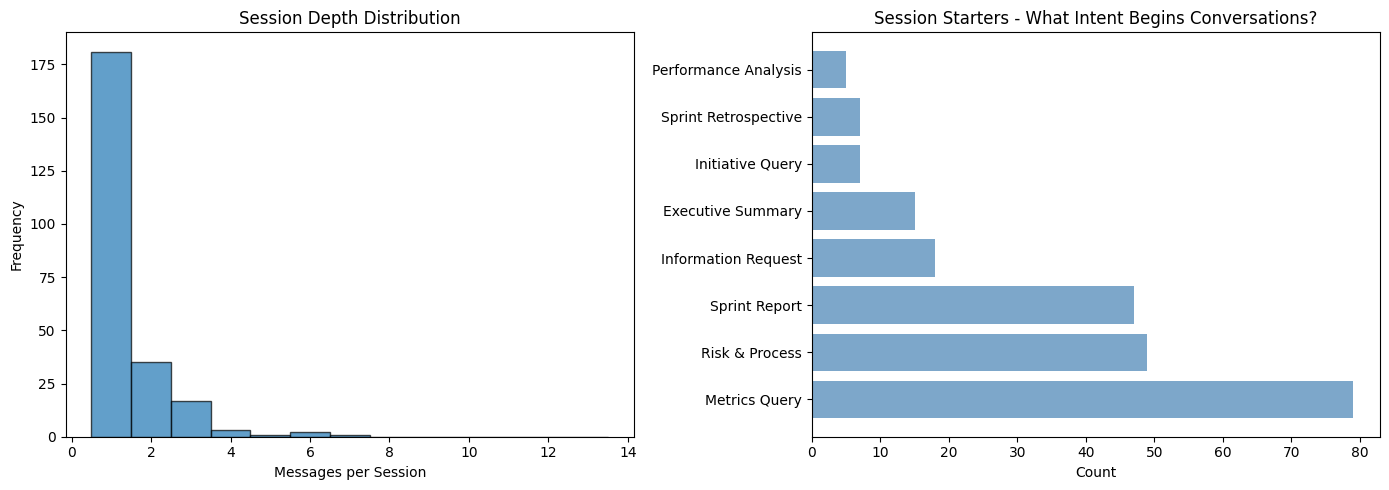

In [18]:
# Session visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Session depth histogram
axes[0].hist(session_lengths, bins=range(1, min(session_lengths.max()+2, 15)), 
             edgecolor='black', alpha=0.7, align='left')
axes[0].set_xlabel('Messages per Session')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Session Depth Distribution')

# First message intent (what starts sessions)
first_msg_intents = df[df['is_first_in_session']]['intent'].value_counts()
first_msg_intents = first_msg_intents[first_msg_intents.index != 'Empty/Invalid']
axes[1].barh(range(len(first_msg_intents)), first_msg_intents.values, color='steelblue', alpha=0.7)
axes[1].set_yticks(range(len(first_msg_intents)))
axes[1].set_yticklabels(first_msg_intents.index)
axes[1].set_xlabel('Count')
axes[1].set_title('Session Starters - What Intent Begins Conversations?')

plt.tight_layout()
plt.savefig(DATA_DIR / 'session_analysis_01_2026.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Token & Complexity Analysis

In [19]:
# Token usage by intent
token_by_intent = df.groupby('intent').agg({
    'total_tokens': ['mean', 'sum', 'count'],
    'prompt_length': 'mean',
    'has_embedded_data': 'mean'
}).round(0)

token_by_intent.columns = ['avg_tokens', 'total_tokens', 'count', 'avg_prompt_len', 'pct_embedded']
token_by_intent['pct_embedded'] = (token_by_intent['pct_embedded'] * 100).round(1)
token_by_intent = token_by_intent.sort_values('count', ascending=False)

print("Token Usage & Complexity by Intent:")
token_by_intent

Token Usage & Complexity by Intent:


,avg_tokens,total_tokens,count,avg_prompt_len,pct_embedded
intent,,,,,
Metrics Query,17852.0,1463850.0,82,14582.0,0.0
Risk & Process,10535.0,368724.0,35,6403.0,100.0
Sprint Report,19674.0,629565.0,32,8687.0,100.0
Information Request,20947.0,272313.0,13,83.0,0.0
Executive Summary,21012.0,231129.0,11,183.0,100.0
Empty/Invalid,6610.0,39657.0,6,23.0,0.0
Initiative Query,26668.0,80003.0,3,64.0,0.0
Sprint Retrospective,12732.0,25464.0,2,101.0,0.0
Performance Analysis,NaN,0.0,0,62.0,0.0


In [20]:
# Embedded data impact
print("Impact of Embedded Data on Prompts:")
for has_data in [False, True]:
    subset = df[df['has_embedded_data'] == has_data]
    label = "With embedded data" if has_data else "Without embedded data"
    print(f"\n{label} ({len(subset)} prompts):")
    print(f"  Avg prompt length: {subset['prompt_length'].mean():.0f} chars")
    print(f"  Avg tokens: {subset['total_tokens'].mean():.0f}")
    print(f"  Top intent: {subset['intent'].value_counts().index[0]}")

Impact of Embedded Data on Prompts:

Without embedded data (167 prompts):
  Avg prompt length: 68 chars
  Avg tokens: 20788
  Top intent: Metrics Query

With embedded data (189 prompts):
  Avg prompt length: 15369 chars
  Avg tokens: 14933
  Top intent: Metrics Query


## 10. Save Analyzed Data

In [21]:
# Save with all analysis columns
df.to_csv(ANALYZED_FILE, index=False)
print(f"Saved analyzed data to: {ANALYZED_FILE}")
print(f"Columns: {list(df.columns)}")

Saved analyzed data to: ../data/flora_data_01_2026_analyzed.csv
Columns: ['id', 'timestamp', 'date', 'hour', 'day_of_week', 'week', 'userId', 'sessionId', 'session_msg_num', 'is_first_in_session', 'prompt', 'response', 'has_embedded_data', 'prompt_length', 'response_length', 'prompt_words', 'response_words', 'model', 'model_simple', 'model_provider', 'input_tokens', 'output_tokens', 'total_tokens', 'stop_reason', 'input_format', 'output_format', 'name', 'environment', 'intent_rules', 'intent_confidence', 'intent_reasoning', 'intent', 'intent_method', 'user_label']


## 11. Executive Summary

In [22]:
print("=" * 70)
print("FLORA USAGE ANALYSIS - JANUARY 2026 - EXECUTIVE SUMMARY")
print("=" * 70)

print(f"\n📊 OVERALL METRICS")
print(f"   Total messages: {len(df)}")
print(f"   Unique users: {df['userId'].nunique()}")
print(f"   Unique sessions: {df['sessionId'].nunique()}")
print(f"   Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")

print(f"\n📈 TOP REQUEST TYPES (Pareto Analysis)")
cumsum = 0
valid_intents = df[df['intent'] != 'Empty/Invalid']['intent'].value_counts()
for intent, count in valid_intents.head(5).items():
    cumsum += count
    pct = count / len(df) * 100
    cum_pct = cumsum / len(df) * 100
    print(f"   {intent}: {count} ({pct:.1f}%) → cumulative: {cum_pct:.1f}%")

print(f"\n👥 USER CONCENTRATION")
user_counts_raw = df['userId'].value_counts()
print(f"   Top 3 users: {user_counts_raw.head(3).sum()/len(df)*100:.1f}% of messages")
print(f"   Top 5 users: {user_counts_raw.head(5).sum()/len(df)*100:.1f}% of messages")

print(f"\n💬 SESSION BEHAVIOR")
print(f"   Single-turn sessions: {single_turn} ({single_turn/len(session_lengths)*100:.1f}%)")
print(f"   Multi-turn sessions: {multi_turn} ({multi_turn/len(session_lengths)*100:.1f}%)")
print(f"   Avg messages/session: {session_lengths.mean():.1f}")

print(f"\n🤖 MODEL USAGE")
for model, count in known_models.items():
    print(f"   {model}: {count} ({count/known_models.sum()*100:.1f}% of known)")
print(f"   Unknown: {model_counts.get('unknown', 0)} ({model_counts.get('unknown', 0)/len(df)*100:.1f}%)")

print(f"\n🎯 CLASSIFICATION QUALITY")
print(f"   Rule-based: {(df['intent_method'] == 'rules').sum()} ({(df['intent_method'] == 'rules').mean()*100:.1f}%)")
if 'llm' in df['intent_method'].values:
    print(f"   LLM fallback: {(df['intent_method'] == 'llm').sum()} ({(df['intent_method'] == 'llm').mean()*100:.1f}%)")
print(f"   Avg confidence: {df['intent_confidence'].mean():.2f}")
print(f"   High confidence (>=0.7): {(df['intent_confidence'] >= 0.7).sum()} ({(df['intent_confidence'] >= 0.7).mean()*100:.1f}%)")

FLORA USAGE ANALYSIS - JANUARY 2026 - EXECUTIVE SUMMARY

📊 OVERALL METRICS
   Total messages: 356
   Unique users: 14
   Unique sessions: 241
   Date range: 2026-01-05 to 2026-01-30

📈 TOP REQUEST TYPES (Pareto Analysis)
   Metrics Query: 140 (39.3%) → cumulative: 39.3%
   Risk & Process: 62 (17.4%) → cumulative: 56.7%
   Sprint Report: 54 (15.2%) → cumulative: 71.9%
   Information Request: 36 (10.1%) → cumulative: 82.0%
   Executive Summary: 17 (4.8%) → cumulative: 86.8%

👥 USER CONCENTRATION
   Top 3 users: 68.0% of messages
   Top 5 users: 93.8% of messages

💬 SESSION BEHAVIOR
   Single-turn sessions: 181 (75.1%)
   Multi-turn sessions: 60 (24.9%)
   Avg messages/session: 1.5

🤖 MODEL USAGE
   claude-sonnet: 180 (97.8% of known)
   gpt-4: 4 (2.2% of known)
   Unknown: 172 (48.3%)

🎯 CLASSIFICATION QUALITY
   Rule-based: 354 (99.4%)
   Avg confidence: 0.85
   High confidence (>=0.7): 318 (89.3%)
